In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, fourier_gaussian
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

# Relevant fonctions

In [2]:
# Pixel window function
def pix_wf(k2d_x, k2d_y):
    t1a = (np.pi*k2d_x)
    t2a = (np.pi*k2d_y)
    t1a[k2d_x == 0] = 1
    t2a[k2d_y == 0] = 1
    term1 = np.sin(np.pi*k2d_x) / t1a
    term2 = np.sin(np.pi*k2d_y) / t2a
    term1[k2d_x == 0] = 1
    term2[k2d_y == 0] = 1
    pix_mn = term1 * term2
    return pix_mn

In [3]:
# Equation A.6
def compute_K(W):
    Nx, Ny = W.shape
    K = np.zeros((Nx, Ny, Nx, Ny), dtype=complex)  # m,n,m1,n1
    
    for n1 in range(Ny):
        for m1 in range(Nx):
            for n in range(Ny):
                for m in range(Nx):
                    if m1 <= m and n1 <= n:
                        K[m, n, m1, n1] = W[m - m1, n - n1,]
                    elif m1 <= m and n1 > n:
                        K[m, n, m1, n1] = W[m - m1, Ny + n - n1]
                    elif m1 > m and n1 <= n:
                        K[m, n,  m1, n1] = W[Nx + m - m1, n - n1]
                    elif m1 > m and n1 > n:
                        K[m, n, m1, n1] = W[Nx + m - m1, Ny + n - n1]
    return K

# Equation A.5
def prod_K(K, T):
    Nx, Ny = T.shape
    O = np.zeros((Nx, Ny), dtype=complex)  # m,n
    
    for n in range(Ny):
        for m in range(Nx):
            O[m, n] = np.sum(K[m, n, :, :] * T) / Nx/Ny
    return O

In [4]:
# Equation 11, 12
def compute_RQ(k2d, kedge, beta=2):
    Nx, Ny = k2d.shape
    Nb = len(kedge)-1
    R = np.zeros((Nx, Ny, Nb))
    Q = np.zeros((Nx, Ny, Nb))
    
    for b in range(Nb):
        wbin = (kedge[b] <= k2d) * (k2d < kedge[b+1])
        sigma = np.sum(wbin) # Number of kmn falling in bin
        for n in range(Ny):
            for m in range(Nx):
                cond = (kedge[b] <= k2d[m,n]) and (k2d[m,n] < kedge[b+1])
                if cond:
                    #R[m,n, b] = 1.0 / sigma 
                    #Q[m,n, b] = 1.0
                    R[m,n, b] = k2d[m,n]**beta / sigma
                    Q[m,n, b] = 1/k2d[m,n]**beta
                else:
                    R[m,n, b] = 0.0
                    Q[m,n, b] = 0.0
    return R, Q

In [5]:
def compute_Mbb_direct(K, R, Q, k2d, kedges, w_mn):
    
    Nx, Ny = K.shape[0], K.shape[1]
    Nb = len(kedges)-1
    idx_bin = np.linspace(0,len(kedge)-2,len(kedge)-1, dtype=int)
    
    mtt_bb = np.zeros((Nb, Nb))

    for m in range(Nx):
        for n in range (Ny):
            w = (k2d[m,n] >= kedge[0:-1]) * (k2d[m,n] < kedge[1:])
            nw = np.sum(w)
            if nw == 1:
                b = idx_bin[w][0]
                p = R[m,n,b]
    
                for m1 in range(Nx):
                    for n1 in range (Ny):
                        w1 = (k2d[m1,n1] >= kedge[0:-1]) * (k2d[m1,n1] < kedge[1:])
                        nw1 = np.sum(w1)
                        if nw1 == 1:
                            b1 = idx_bin[w1][0]
                            q = Q[m1,n1,b1]
                            
                            mtt_bb[b1,b] = mtt_bb[b1,b] + p*np.abs(K[m,n,m1,n1])**2*q
    return mtt_bb.T / (Nx*Ny)**2

In [6]:
def compute_Mbb(R, K, Q):
    Nx, Ny = R.shape[0], R.shape[1]
    Nb = R.shape[2]
    Mbb = np.zeros((Nb, Nb))
    for ib in range(Nb):
        for jb in range(Nb):            
                sum_KQ  = np.sum(np.abs(K)**2 * (Q[:,:,jb])[np.newaxis, np.newaxis, :, :], axis=(2,3))
                sum_RKQ = np.sum(R[:,:,ib] * sum_KQ)
                Mbb[ib, jb] = sum_RKQ
    return Mbb/(Nx*Ny)**2

# Define the data

### Mask definition and image parameters

In [7]:
# Map size and reso
Nx, Ny = 31, 41
reso = 1.0
mapscale = 1

# Smoothing
smooth = 0
smooth_mask = 0

# Input Pk
kcut = 1e-1
beta_spec = 11.0/3
beta_bin = 0
kpiv = 0.2
norm = 1

# Pk binning
binscale = 'log'
Nbin = 5

In [8]:
# Number of pixels to add on each side to avoid aliasing effects
Nadd_x = int((Nx*mapscale-Nx)/2)
Nadd_y = int((Ny*mapscale-Ny)/2)
Nx_add, Ny_add = int(Nx + 2*Nadd_x), int(Ny + 2*Nadd_y)

In [9]:
k_x = np.fft.fftfreq(Nx, reso)
k_y = np.fft.fftfreq(Ny, reso)
k2d_x, k2d_y = np.meshgrid(k_x, k_y, indexing='ij')
k2d = np.sqrt(k2d_x**2 + k2d_y**2)

kmin = 1/reso/np.amax([Nx, Ny])
kmax = 1/reso/2

kmin = np.amin(k2d[k2d > 0])
kmax = np.amax(k2d)

if binscale == 'lin': kedge = np.linspace(kmin, kmax, Nbin+1)
if binscale == 'log': kedge = np.logspace(np.log10(kmin), np.log10(kmax), Nbin+1)
kvals = 0.5 * (kedge[1:] + kedge[:-1])

k_x_add = np.fft.fftfreq(Nx_add, reso)
k_y_add = np.fft.fftfreq(Ny_add, reso)
k2d_x_add, k2d_y_add = np.meshgrid(k_x_add, k_y_add, indexing='ij')
k2d_add = np.sqrt(k2d_x_add**2 + k2d_y_add**2)

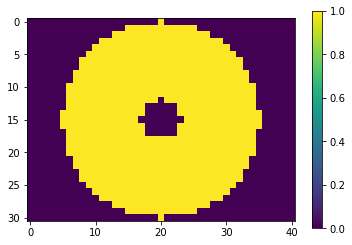

In [10]:
mask = np.zeros((Nx, Ny))+1

x = np.linspace(-Nx/2*reso, +Nx/2*reso, Nx)
y = np.linspace(-Ny/2*reso, +Ny/2*reso, Ny)
x2d, y2d = np.meshgrid(x, y, indexing='ij')
rad = np.sqrt(x2d**2 + y2d**2)

# Always mask outside pixels
mask[rad > Nx/2*reso] = 0
mask[rad < Nx*reso/10] = 0

FT_mask = np.fft.fft2(mask)
FT_mask = fourier_gaussian(FT_mask, sigma=smooth_mask/(2*np.sqrt(2*np.log(2)))/reso)
mask = np.real(np.fft.ifft2(FT_mask))

fft_mask  = np.fft.fftn(mask)

plt.imshow(mask)
plt.colorbar()

In [11]:
# Compute K matrix
start = time.time()
K = compute_K(fft_mask)
end = time.time()
print('Computing time K (s):', end - start)

# Compute R,Q matrix
start = time.time()
R,Q = compute_RQ(k2d, kedge, beta=beta_bin)
end = time.time()
print('Computing time R,Q (s):', end - start)

# Compute Mbb matrix
start = time.time()
Mbb = compute_Mbb(R, K, Q)
end = time.time()
print('Computing time Mbb (s):', end - start)

#start = time.time()
#Mbb_direct = compute_Mbb_direct(K, R, Q, k2d, kedge, fft_mask)
#end = time.time()
#print('Computing time Mbb_direct (s):', end - start)

Computing time K (s): 0.5648167133331299
Computing time R,Q (s): 0.0062410831451416016
Computing time Mbb (s): 0.2754249572753906


Text(0.5, 1.0, 'Mbb my method')

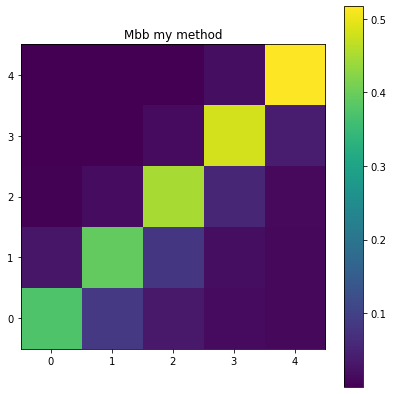

In [12]:
plt.figure(1, figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(Mbb, origin='lower')
plt.colorbar()
plt.title('Mbb my method')

#plt.subplot(1,2,2)
#plt.imshow(Mbb_direct, origin='lower')
#plt.colorbar()
#plt.title('Mbb brute force method')

### Map realization

In [13]:
Nmc = 1000
Pk_RT_mc  = np.zeros((Nmc, Nbin)) # |FFT image|^2 convolved with binning matrix R
Pk_Mbb_mc = np.zeros((Nmc, Nbin)) # |FFT image|^2 convolved with binning matrix R and multiplied by Mbb to mimic mask
#Pk_MbbD_mc = np.zeros((Nmc, Nbin)) # |FFT image|^2 convolved with binning matrix R and multiplied by Mbb to mimic mask
Pk_ixm_mc = np.zeros((Nmc, Nbin)) # |FFT image x mask|^2 with standard bining
Pk_img_mc = np.zeros((Nmc, Nbin)) # |FFT image|^2 with standard bining
Pk_D_mc   = np.zeros((Nmc, Nbin)) # |FFT image|^2 multiplied by K matrix and then with standard bining

for imap in range(Nmc):
    # Compute the map
    amplitude = norm * (k2d_add/kpiv)**-(beta_spec/2) * (np.exp(-(kcut/k2d_add)**2))**0.5
    amplitude[k2d_add == 0] = 0
    image = np.random.normal(0,1, (Nx_add, Ny_add))
    fftfield = np.fft.fftn(image) * amplitude
    image = np.real(np.fft.ifftn(fftfield))
    image = image[Nadd_x:Nx_add-Nadd_x, Nadd_y:Ny_add-Nadd_y]
    
    # Smoothing
    if smooth>0:
        FT_map = np.fft.fft2(image)
        FT_map = fourier_gaussian(FT_map, sigma=smooth/(2 * np.sqrt(2*np.log(2)))/reso)
        image = np.real(np.fft.ifft2(FT_map))
        
    # FFT
    fft_ixm = np.fft.fftn(image*mask - np.mean(image*mask))
    fft_image = np.fft.fftn(image - np.mean(image))
    
    # Compute D = sum K # fft
    D = prod_K(K, fft_image)
    
    # Compute binnied Pk using R matrix
    Pk_RT = np.sum(R*(np.abs(fft_image)**2)[:,:,np.newaxis], axis=(0,1))
    Pk_Mbb = np.matmul(Mbb, Pk_RT)
    #Pk_Mbb_direct = np.matmul(Mbb_direct, Pk_RT)
    
    # Bin the Pk
    Pk_ixm, _, _   = stats.binned_statistic(k2d.flatten(), k2d.flatten()**beta_bin*np.abs(fft_ixm.flatten())**2,   statistic="mean", bins=kedge)
    Pk_image, _, _ = stats.binned_statistic(k2d.flatten(), k2d.flatten()**beta_bin*np.abs(fft_image.flatten())**2, statistic="mean", bins=kedge)
    Pk_D, _, _     = stats.binned_statistic(k2d.flatten(), k2d.flatten()**beta_bin*np.abs(D.flatten())**2,         statistic="mean", bins=kedge)
    
    # Fill the data
    Pk_RT_mc[imap,:]  = Pk_RT
    Pk_Mbb_mc[imap,:] = Pk_Mbb
    #Pk_MbbD_mc[imap,:] = Pk_Mbb_direct
    Pk_ixm_mc[imap,:] = Pk_ixm
    Pk_img_mc[imap,:] = Pk_image
    Pk_D_mc[imap,:]   = Pk_D

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


# Output the results

Text(0.5, 1.0, 'Relative mean difference')

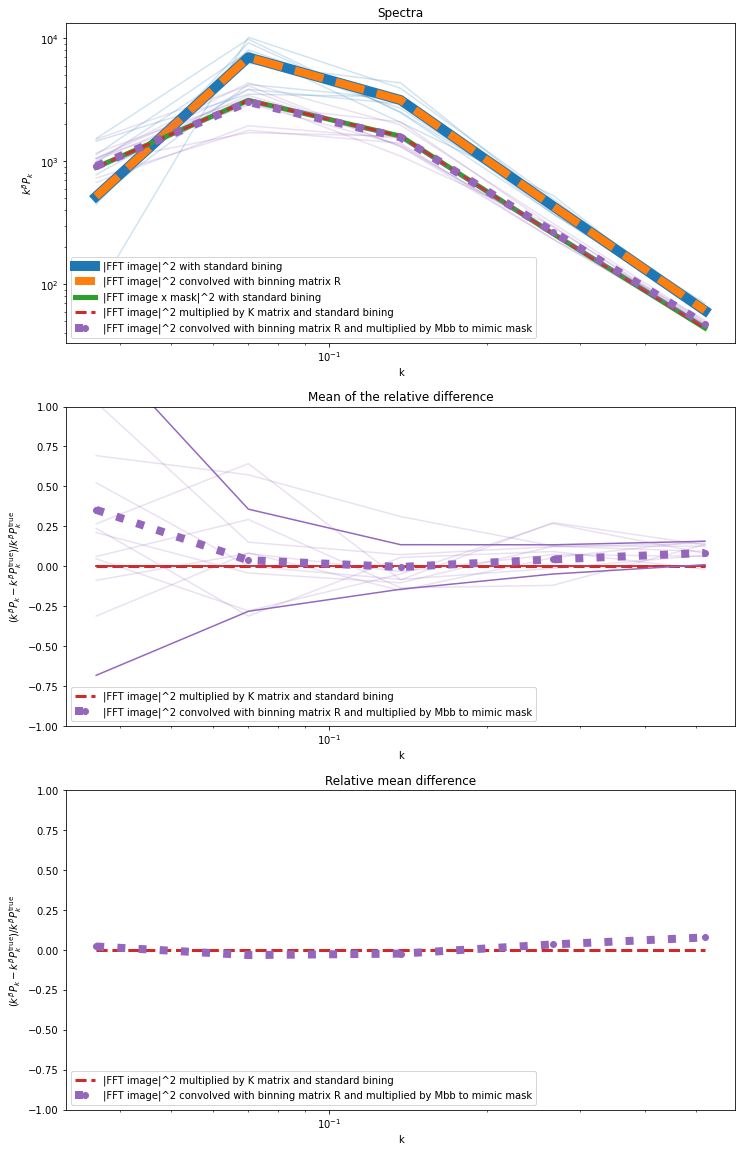

In [14]:
# Mean spec
Pk_RT_m  = np.mean(Pk_RT_mc, axis=0)
Pk_Mbb_m = np.mean(Pk_Mbb_mc, axis=0)
#Pk_MbbD_m = np.mean(Pk_MbbD_mc, axis=0)
Pk_ixm_m = np.mean(Pk_ixm_mc, axis=0)
Pk_img_m = np.mean(Pk_img_mc, axis=0)
Pk_D_m   = np.mean(Pk_D_mc, axis=0)

Pk_RT_s  = np.std(Pk_RT_mc, axis=0)
Pk_Mbb_s = np.std(Pk_Mbb_mc, axis=0)
#Pk_MbbD_s = np.std(Pk_MbbD_mc, axis=0)
Pk_ixm_s = np.std(Pk_ixm_mc, axis=0)
Pk_img_s = np.std(Pk_img_mc, axis=0)
Pk_D_s   = np.std(Pk_D_mc, axis=0)

# Diff spec
Pk_D_diff_mc = (Pk_D_mc-Pk_ixm_mc)/Pk_ixm_mc
Pk_Mbb_diff_mc = (Pk_Mbb_mc-Pk_ixm_mc)/Pk_ixm_mc

Pk_D_diff_m = np.mean(Pk_D_diff_mc, axis=0)
Pk_Mbb_diff_m = np.mean(Pk_Mbb_diff_mc, axis=0)
Pk_D_diff_s = np.std((Pk_D_mc-Pk_ixm_mc)/Pk_ixm_mc, axis=0)
Pk_Mbb_diff_s = np.std((Pk_Mbb_mc-Pk_ixm_mc)/Pk_ixm_mc, axis=0)

# Plot
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(1, figsize=(12,20))
plt.subplot(3,1,1)
plt.loglog(kvals, Pk_img_m, label='|FFT image|^2 with standard bining', lw=10, color=colors[0])
#plt.loglog(kvals, Pk_img_m+Pk_img_s, color=colors[0])
#plt.loglog(kvals, Pk_img_m-Pk_img_s, color=colors[0])
for i in range(10): plt.loglog(kvals, Pk_img_mc[i,:], color=colors[0], alpha=0.2)
plt.loglog(kvals, Pk_RT_m, label='|FFT image|^2 convolved with binning matrix R', lw=8, ls='--', color=colors[1])
plt.loglog(kvals, Pk_ixm_m, label='|FFT image x mask|^2 with standard bining', lw=5, color=colors[2])
plt.loglog(kvals, Pk_D_m, label='|FFT image|^2 multiplied by K matrix and standard bining', lw=3, ls='--', color=colors[3])
plt.loglog(kvals, Pk_Mbb_m, label='|FFT image|^2 convolved with binning matrix R and multiplied by Mbb to mimic mask', lw=8, ls=':', marker='o', color=colors[4])
for i in range(10): plt.loglog(kvals, Pk_Mbb_mc[i,:], color=colors[4], alpha=0.2)
#plt.loglog(kvals, Pk_MbbD_m, label='Mbb direct', lw=3, ls='--', marker='s', color=colors[5])
plt.legend(loc='lower left')
plt.xlabel('k')
plt.ylabel(r'$k^{\beta} P_k$')
plt.title('Spectra')

plt.subplot(3,1,2)
plt.plot(kvals, Pk_D_diff_m, label='|FFT image|^2 multiplied by K matrix and standard bining', lw=3, ls='--', color=colors[3])
plt.plot(kvals, Pk_D_diff_m-Pk_D_diff_s, color=colors[3])
plt.plot(kvals, Pk_D_diff_m+Pk_D_diff_s, color=colors[3])
plt.plot(kvals, Pk_Mbb_diff_m, label='|FFT image|^2 convolved with binning matrix R and multiplied by Mbb to mimic mask', lw=8, ls=':', marker='o', color=colors[4])
plt.plot(kvals, Pk_Mbb_diff_m-Pk_Mbb_diff_s, color=colors[4])
plt.plot(kvals, Pk_Mbb_diff_m+Pk_Mbb_diff_s, color=colors[4])
for i in range(10): plt.plot(kvals, Pk_Mbb_diff_mc[i,:], color=colors[4], alpha=0.2)
#plt.plot(kvals, (Pk_MbbD_m-Pk_ixm_m)/Pk_ixm_m, label='Mbb direct', lw=3, ls='--', marker='s', color=colors[5])
plt.legend(loc='lower left')
plt.xlabel('k')
plt.xscale('log')
plt.ylabel(r'$(k^{\beta} P_k - k^{\beta} P^{\rm true}_k)/k^{\beta} P^{\rm true}_k$')
plt.ylim(-1,1)
plt.title('Mean of the relative difference')

plt.subplot(3,1,3)
plt.plot(kvals, (Pk_D_m-Pk_ixm_m)/Pk_ixm_m, label='|FFT image|^2 multiplied by K matrix and standard bining', lw=3, ls='--', color=colors[3])
plt.plot(kvals, (Pk_Mbb_m-Pk_ixm_m)/Pk_ixm_m, label='|FFT image|^2 convolved with binning matrix R and multiplied by Mbb to mimic mask', lw=8, ls=':', marker='o', color=colors[4])
#plt.plot(kvals, (Pk_MbbD_m-Pk_ixm_m)/Pk_ixm_m, label='Mbb direct', lw=3, ls='--', marker='s', color=colors[5])
plt.legend(loc='lower left')
plt.xlabel('k')
plt.xscale('log')
plt.ylabel(r'$(k^{\beta} P_k - k^{\beta} P^{\rm true}_k)/k^{\beta} P^{\rm true}_k$')
plt.ylim(-1,1)
plt.title('Relative mean difference')

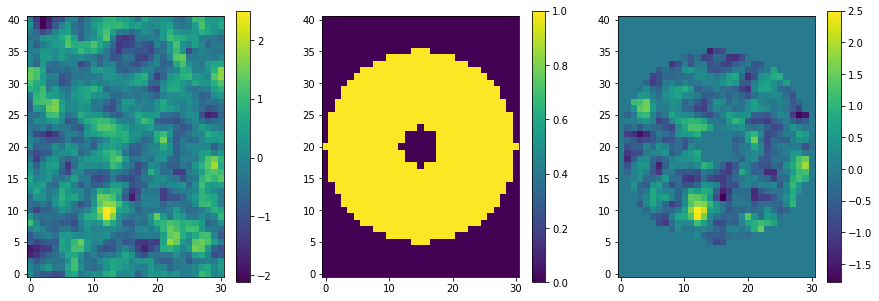

In [15]:
plt.figure(0, figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image.T, origin='lower')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(mask.T, origin='lower')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow((image*mask).T, origin='lower')
plt.colorbar()